# Dimensionality Reduction Tools for Data Mining and Index Construction Using Factor Analysis and PCA

In this Jupyter notebook, we will calculate different Composite Indices for the Kathmandu Valley at the ward level. The indicators in the dataframe were produced and preprocessed using data from the Housing and Population Census (2011 and 2021) provided by Nepal's Central Bureau of Statistics (CBS), along with additional geoprocessed data from OpenStreetMap (OSM). 

Steps:

0. Import Libraries and Data Preprocessing
1. Exploratory Factor Analysis (EFA)
2. Principal Component Analysis (PCA)
3. Composite Index Creation

Lets start.

First of all, install the necessary libraries

In [2]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install factor_analyzer

Defaulting to user installation because normal site-packages is not writeable


### 0. Import libraries and set workspace

In [5]:
# Import required libraries
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from scipy import stats
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML

In [18]:
# Load the CSV file using pandas
df = pd.read_csv(r"C:\GIS\G8\Kathmandu\scripts\census_ward_new_2021B.csv", header=0, sep=";", decimal=".")

In [19]:
display(HTML(df.to_html()))

### Create new variables and different thematic dataframes for data exploration

In [7]:
# 1) Demographic Characteristics

# Calculate variables
# Sex ratio evolution
df['sex_rEv'] = (df['popm21'] / df['popf21']) - (df['popm11'] / df['popf11']) #df['sex_r21']
# Population living in informal settlement
df['popSqt'] = df['SUM_poptSq'] / df['popt21']
# Child dependency
#df['childDep'] = (df['popt21'] - df['pop21p9y']) / df['popt21']
# Low population density
df['popLDsty21'] = 1 - df['popDsty21']
# No child marriage
df['NChldMarT'] = 1 - df['ChldMarT']

# Create a list and a dfFrame with demographic indicators
#demographic = [ 'poptAAGR', 'sex_rEv',  'popMom', 'DepChild', 'ChildWork','ChildNWork','ChildHWork']
#demographic_df = df[demographic]

# 2) Socioeconomic Status

# Calculate variables
# no active and no employed
df['popNAct'] = 1 - df['r_popActEm']
# Inverse Literacy rate
df['popNLitRate'] = 100 - df['popLitRate']

# Create a list and a df with Socioeconomic indicators
#socioeconomic = [ 'popActUe', 'popNUAct', 'popDNAct', 'popRdW_1', 
  #                'popRdY', 'popNever' ]
#socioeconomic_df = df[socioeconomic]

# 3) Housing Conditions

# Calculate variables
# Households that dont have reinforced concrete foundation
df['HhFuNRein'] = 1 - df['r_HhFuRein']

# Create a list and a dfFrame with demographic indicators
#housing = ['HhORente', 'ahhSize21','HhTPit', 'HhTWitho', 'HhFuNRein']
#housing_df = df[housing]

# 4) Access to Basic Services and Amenities

# Calculate variables
# No access to passive communication technology 
#   No access to Radio 
df['HhAmNRadi'] = 1 - df['r_HhAmRadi']
#   No access to Television
df['HhAmNTV'] = 1 - df['r_HhAmTV']
# No access to ordinary mobile telephone
df['HhAmNMob'] = 1 - df['r_HhAmMobi']
# No access to fix telephone
df['HhAmNTelF'] = 1 - df['r_HhAmTelF']
# No access to information technology 
#   No access to smartphone
df['HhAmNSmart'] = 1 - df['r_HhAmMo_1']
#   No access to Internet
df['HhAmNInte'] = 1 - df['r_HhAmInte']
# No access to public transport within a 5-10 minute walk (Euclidean distance)
df['popN5minPT'] = 1 - df['pop5minPT']
# No access to private transport (Car)
df['HhAmNCar'] = 1 - df['r_HhAmCar']
# No access to private transport (Motor cycle)
df['HhAmNMoto'] = 1 - df['r_HhAmMoto']
# No access to refrigerator
df['HhAmNRefr'] = 1 - df['r_HhAmRefr']
# Private transport
df['HhAmPvtT'] = (df['r_HhAmMoto']+df['r_HhAmCar'])/2
# Covered and uncovered well
df['HhWWell'] = (df['r_HhWCvwel']+df['r_HhWUcvwe'])/2

# Create a list and a dfFrame with demographic indicators
#amenities = ['r_HhWTbewe', 'r_HhWCvwel', 'r_HhWUcvwe', 'r_HhWSpout',  
 #           'r_HhAmNRadi', 'r_HhAmNTV', 'r_HhAmNMob',  
 #            'HhAmNInte', 'popN5minPT', 'HhAmNCar', 'HhAmNMoto'] # 'HhAmNTelF','HhAmNa', 'HhAmNSmart',
#amenities_df = df[amenities]


In [8]:
# Find columns with null values
list_na = df.columns[df.isnull().any()].tolist()
print(list_na)


['DAN', 'F_1', 'F_2', 'F_3', 'F_4']


In [9]:
# Show structure of the data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Columns: 258 entries, OBJECTID to HhWWell
dtypes: float64(183), int64(69), object(6)
memory usage: 463.7+ KB
None


# 1. Exploratory Factor analysis
In this first half of the code we will explore our variables and define the underlying constructs or factors in the data.

In Factor Analysis, a construct refers to an abstract concept or latent variable that is not directly observable but is inferred from the relationships between observed variables. Constructs represent underlying dimensions or factors that explain the patterns of correlations among a set of measured variables.

For example, in social sciences, constructs might represent things like personality, social class or neighbourhood identity, which can't be measured directly. Instead, factor analysis uses multiple observed variables (e.g., income, education level, access to amenities) to determine how they correlate with one another. The shared variance among these observed variables suggests the presence of an underlying construct that influences them.

### A. Choose variables and set dataframe for exploratory factor analysis 

In [10]:
# We will iterate this process trough the varables in our df, grouping and excluding until we have coherent constructs
# We can start selecting a set of variables that corresponds to a dimension or concept that we want to measure

# Or we can just input the entire dataset [df] and see what happens :) 

# all variables
fa =[
'r_HhOOwned', 'r_HhORente', 'r_HhOInsti',  # Ownership
'HhMAdequate', 'HhAdequate', 'HhModerate', 'HhInadequate', 'HhLstAdequate',  # Quality of House
'r_HhFuMud', 'r_HhFuCem', 'r_HhFuRein', 'HhFuNRein','r_HhFuWood',  # House foundation material
'r_HhWTapCl', 'r_HhWTapFa', 'r_HhWTbewe', 'r_HhWCvwel', 'r_HhWUcvwe', 'r_HhWSpout', 'r_HhWbottl', 'HhWWell',  # Drinking water
'r_HhTFlush', 'r_HhTFlu_1', 'r_HhTPit', 'r_HhTPubli', 'r_HhTWitho', 'HhAmPvtT',  # Toilet
'r_HhAmNa', 'r_HhAmOne', 'r_HhAmFan', 'r_HhAmRefr', 'r_HhAmWash', 'r_HhAmAirC','HhAmNRefr',  # Amenities Comfort
'r_HhAmRadi', 'r_HhAmTV', 'r_HhAmTelF', 'r_HhAmMobi', 'r_HhAmMo_1', 'r_HhAmComp', 'r_HhAmInte', 'HhAmNInte', # Communication
'r_HhAmCar', 'r_HhAmMoto', 'r_HhAmBicy', 'pop5minPT', 'popN5minPT','HhAmNMoto', 'HhAmNCar', # Transport
    
'r_popRdWrt', 'r_popRdY', 'r_popRdW_1', 'r_popLitRa',  # Literacy pop > 5 y/o
'LitRatM15', 'LitRatF15', 'LitRatT15',  # Literacy youth pop < 15 y/o
'LitRAdultT', 'LitRAdultM', 'LitRAdultF',  # Literacy adult pop >= 15 y/o
'r_popCurrA', 'r_popEverA', 'r_popNever',   # School Attendance Pop 5 to 25 y/o
'CurrAtt17', 'EverAtt17', 'NeverAtt17',  # School Attendance Pop 5 to 17 y/o
'EdLvlBaT', 'EdLvlBaM', 'EdLvlBaF', 'EdLvlSeT', 'EdLvlSeM', 'EdLvlSeF','EdLvlHiT', 'EdLvlHiM', 'EdLvlHiF',  # Educational attainment

'r_popActEm', 'r_popActUe', 'r_popNUAct', 'r_popDNAct', 'popNAct', # Economic activity Pop 10+ y/o
'EmpAgriYes', 'EmpAgriNo',  # Agricole employment
'Work10yT', 'Work10yM', 'Work10yF', 'WorkHh10yT', 'WorkHh10yM', 'WorkHh10yF','WorkNo10yT', 'WorkNo10yM', 'WorkNo10yF',  # Employment sector and sex
'Work6mT', 'Work6mM', 'Work6mF', 'Work6_3mT', 'Work6_3mM', 'Work6_3mF','Work3mT', 'Work3mM', 'Work3mF',  # Economic work within last 12 months

'househld11', 'popt11', 'popm11', 'popf11', 'ahhSize11', 'sex_r11',  # 2011 Demographic Data
'househld21', 'popt21', 'popm21', 'popf21', 'ahhSize21', 'sex_r21',  # 2021 Demographic Data
'popDsty21',  'popLDsty21',  'poptTG1121', 'poptAAGR', 'ahSize1121', 'sex_rEv',  # Pop density and growth
'Urban', 'PeriUrban', 'Rural',  # Urbanisation status
'FamilyNucl', 'FamilyExtd',  # Family structure
'MigrantNo', 'MigrantInt', 'MigrantFor',   # Migration status
'popSqt', 'MEAN_HhSiz',  # Informal settlement population
'DepChild', 'DepElderly', 'DepTot',  # Dependency
'DisabilRte',  # Disability rate
'Poorest', 'Poorer', 'Middle', 'Richer', 'Richest',  # Wealth Quintile
'Window', 'SingleWomn',  # Widow and Single Woman status
'ChldMarT', 'ChldMarM', 'ChldMarF', 'NChldMarT', # Child Marriage
'AbsInHh', 'AbsInPTT', 'AbsInPT', 'AbsInPM', 'AbsInPF', 'AbsOutHh', 'AbsOutPTT', 
'AbsOutPT', 'AbsOutPM', 'AbsOutPF',  # Absent household members
'HhHeadM', 'HhHeadF',  # Head of household
'ChildWork', 'ChildHWork', 'ChildNWork',  # Child labor 10 - 17 y/o
'r_popMomDa', 'r_popMom', 'r_popDad', 'r_popDadSM', 'r_popMomSD', 
'r_popOther', 'r_popEmplo'  # Living with minor status
]
fa_data = df[fa]

In [11]:
# Find columns with null values
list_na = fa_data.columns[fa_data.isnull().any()].tolist()
print(list_na)

[]


In [12]:
display(HTML(fa_data.to_html()))

### B. Check for Suitability
Perform the KMO and Bartlett’s tests to check if your data is suitable for factor analysis.

#### 0. Normality testing
Testing for normality before applying Factor analysis or Principal Component Analysis (PCA) is a common practice in statistical analysis, particularly for datasets that are assumed to have multivariate normal distribution. Here are some reasons why normality tests are often conducted prior to EFA/PCA:

#### **Assumption of Normality**:
   - **Underlying Assumption**: PCA is a linear method that assumes the data are normally distributed. This assumption helps ensure that the relationships between the variables are valid for linear transformations. When data are normally distributed, it provides more reliable estimates of the variance and covariance structures used in PCA.

#### **Interpretation of Results**:
   - **Factor Loadings and Scores**: If the data are normally distributed, the interpretation of the factor loadings and component scores becomes more straightforward. Non-normally distributed data might lead to misleading loadings and scores, making it harder to draw meaningful conclusions.

#### **Influence of Outliers**:
   - **Sensitivity to Outliers**: PCA is sensitive to outliers, which can skew the results and affect the direction and magnitude of the principal components. Testing for normality helps identify outliers that might violate the assumptions of the analysis.

#### **Distribution of Principal Components**:
   - **Interpretation of Components**: When the original variables are normally distributed, the principal components derived from them are also more likely to be normally distributed. This is important for further statistical analyses that may rely on the assumption of normality, such as regression or hypothesis testing based on the principal components.

#### **Statistical Validity**:
   - **Statistical Tests**: Many statistical tests that follow PCA (such as further modeling or hypothesis testing) assume normality of the data. If the data are not normally distributed, the validity of these tests may be compromised.

#### **Alternative Methods**:
   - **Non-Normal Data Handling**: If the data are found to be non-normally distributed, you might consider transforming the data (e.g., using logarithmic or Box-Cox transformations) to achieve normality before applying PCA. Alternatively, non-linear dimensionality reduction techniques (like t-SNE or UMAP) might be more suitable for non-normally distributed data.

#### **Dimensionality Reduction Goals**:
   - **Preserving Structure**: PCA aims to reduce dimensionality while preserving as much variance as possible. If the data violate normality, the principal components may not represent the underlying structure effectively, leading to suboptimal dimensionality reduction.

C:\Users\janot\AppData\Local\Temp\ipykernel_28136\345864002.py:7: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


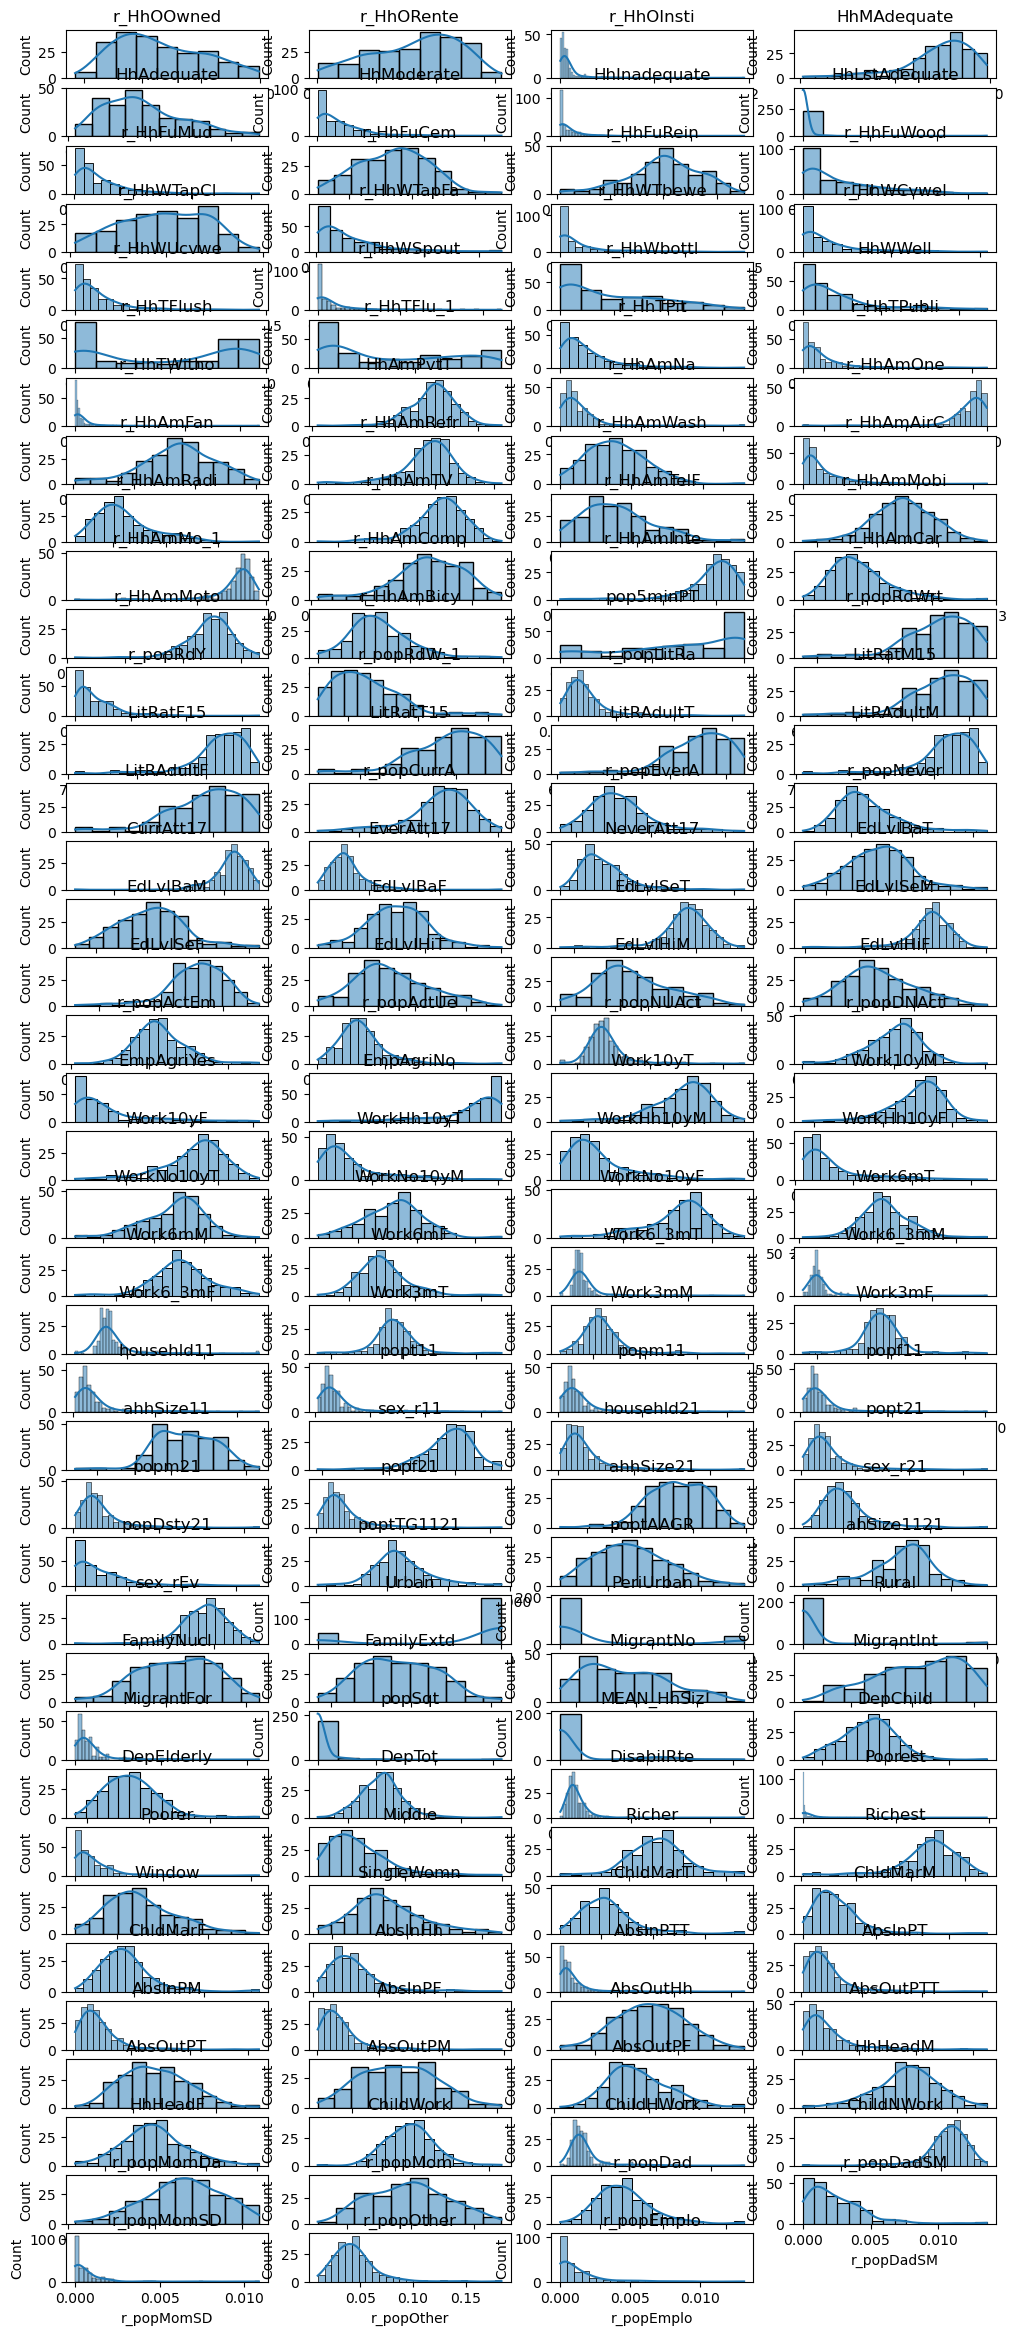

In [15]:
# Visualize distributions of not normalised indicators
plt.figure(figsize=(12, 30))
for i, column in enumerate(fa_data.columns):
    plt.subplot(40, 4, i + 1)
    sns.histplot(fa_data[column].dropna(), kde=True)
    plt.title(column)
plt.tight_layout()
plt.show()

#### Normalisation of the variables
The following code aims to normalize non-normal variables in the dataset by applying and selecting the best transformation (log, sqrt, Box-Cox, Yeo-Johnson) to improve normality.

Here’s a brief explanation of the key parts of the code:

1. **Normality Check**: The code first checks which variables are normally distributed using the Shapiro-Wilk test. It loops through each column in `fa_data` and stores the results (test statistic and p-value). Variables that are not normally distributed are identified and stored in `non_normal_vars`.

2. **Transformation Function**: The `transform_variable` function applies different transformations to each variable, such as:
   - **Log transformation** (for positive values)
   - **Square root transformation** (for non-negative values)
   - **Box-Cox transformation** (for strictly positive values)
   - **Yeo-Johnson transformation** (works for all values)
   It also performs the Shapiro-Wilk test on each transformed version to assess normality.

3. **Select Best Transformation**: After applying all transformations, the code selects the one that yields the highest Shapiro-Wilk test statistic (indicating the closest to normal distribution).

4. **Store Transformed Data**: The best transformation for each variable is stored in a dictionary, and at the end, all transformed variables are concatenated into a new DataFrame `fa_ndata`.

In [13]:
# Step 1: Shapiro-Wilk normality check function
def check_normality(data):
    normality_results = {}
    for column in data.select_dtypes(include=['float64', 'int64']).columns:
        if data[column].nunique() > 1:  # Only check if there's variance
            stat, p_value = stats.shapiro(data[column])
            normality_results[column] = {
                'Statistic': stat,
                'p-value': p_value,
                'Normal': p_value > 0.05  # If p > 0.05, data is normally distributed
            }
        else:
            normality_results[column] = {
                'Statistic': None,
                'p-value': None,
                'Normal': False  # Treat it as not normal
            }
    return pd.DataFrame(normality_results).T

# Step 2: Function to apply transformations and calculate Shapiro-Wilk statistic
def transform_variable(var_name, data):
    shapiro_dict = {}
    original_data = data[var_name].dropna()  # Drop NaNs to avoid issues during transformation

    if original_data.nunique() > 1:  # Check if there's variance
        # 1. Original variable (no transformation)
        stat, p_value = stats.shapiro(original_data)
        shapiro_dict[var_name] = stat  # Save the statistic, we will check p-value later
    else:
        shapiro_dict[var_name] = None

    # 2. Log transformation (only for positive values)
    if (original_data > 0).all():
        log_data = np.log(original_data)
        shapiro_dict[f"log_{var_name}"] = stats.shapiro(log_data)[0]
    
    # 3. Square root transformation (non-negative values)
    if (original_data >= 0).all():
        sqrt_data = np.sqrt(original_data)
        shapiro_dict[f"sqrt_{var_name}"] = stats.shapiro(sqrt_data)[0]

    # 4. Box-Cox transformation (strictly positive values)
    if (original_data > 0).all():
        try:
            boxcox_data, _ = stats.boxcox(original_data)
            shapiro_dict[f"boxcox_{var_name}"] = stats.shapiro(boxcox_data)[0]
        except ValueError:
            print(f"Box-Cox transformation failed for {var_name}")

    # 5. Yeo-Johnson transformation (works with all values)
    try:
        pt = PowerTransformer(method='yeo-johnson')
        yjt_data = pt.fit_transform(original_data.values.reshape(-1, 1)).flatten()
        shapiro_dict[f"yjt_{var_name}"] = stats.shapiro(yjt_data)[0]
    except Exception as e:
        print(f"Yeo-Johnson transformation failed for {var_name}: {e}")
    
    return shapiro_dict

# Step 3: Identify non-normal variables and apply transformations
def apply_transformations(data):
    # Step 1: Check for normality of all variables
    normality_df = check_normality(data)
    non_normal_vars = normality_df[normality_df['Normal'] == False].index.tolist()

    shapiro_results = {}
    best_transformations = {}
    
    # Dictionary to hold transformed variables
    transformed_data_dict = {}
    
    # Loop through non-normal variables and apply transformations
    for var in non_normal_vars:
        shapiro_dict = transform_variable(var, data)
        shapiro_results[var] = shapiro_dict
        
        # Select the best transformation (highest Shapiro-Wilk statistic)
        best_transformation = max(shapiro_dict, key=shapiro_dict.get)
        best_transformations[var] = best_transformation
        
        # Apply the best transformation
        original_data = data[var].dropna()
        if best_transformation == var:
            transformed_series = original_data  # No transformation needed
        elif "log_" in best_transformation:
            transformed_series = np.log(original_data)
        elif "sqrt_" in best_transformation:
            transformed_series = np.sqrt(original_data)
        elif "boxcox_" in best_transformation:
            transformed_series, _ = stats.boxcox(original_data)
        elif "yjt_" in best_transformation:
            pt = PowerTransformer(method='yeo-johnson')
            transformed_series = pt.fit_transform(original_data.values.reshape(-1, 1)).flatten()
        
        # Store the transformed series in the dictionary
        transformed_data_dict[var] = transformed_series

    # Convert the dictionary to a DataFrame
    transformed_data = pd.DataFrame(transformed_data_dict, index=data.index)
    
    # Ensure that all original variables are included in the final DataFrame
    final_data = data.copy()  # Create a copy of the original data
    final_data.update(transformed_data)  # Update with transformed data where applicable

    return final_data, best_transformations

# Step 4: Run the process and print results
fa_data_normalized, best_transformations = apply_transformations(fa_data)



print("Best transformations for each variable:")
print(best_transformations)


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\scipy\stats\morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


Best transformations for each variable:
{'r_HhOOwned': 'boxcox_r_HhOOwned', 'r_HhORente': 'yjt_r_HhORente', 'r_HhOInsti': 'yjt_r_HhOInsti', 'HhMAdequate': 'yjt_HhMAdequate', 'HhAdequate': 'boxcox_HhAdequate', 'HhModerate': 'boxcox_HhModerate', 'HhInadequate': 'yjt_HhInadequate', 'HhLstAdequate': 'yjt_HhLstAdequate', 'r_HhFuMud': 'boxcox_r_HhFuMud', 'r_HhFuRein': 'yjt_r_HhFuRein', 'HhFuNRein': 'boxcox_HhFuNRein', 'r_HhFuWood': 'sqrt_r_HhFuWood', 'r_HhWTapCl': 'yjt_r_HhWTapCl', 'r_HhWTapFa': 'boxcox_r_HhWTapFa', 'r_HhWTbewe': 'sqrt_r_HhWTbewe', 'r_HhWCvwel': 'sqrt_r_HhWCvwel', 'r_HhWUcvwe': 'yjt_r_HhWUcvwe', 'r_HhWSpout': 'yjt_r_HhWSpout', 'r_HhWbottl': 'sqrt_r_HhWbottl', 'HhWWell': 'sqrt_HhWWell', 'r_HhTFlush': 'sqrt_r_HhTFlush', 'r_HhTFlu_1': 'boxcox_r_HhTFlu_1', 'r_HhTPit': 'yjt_r_HhTPit', 'r_HhTPubli': 'yjt_r_HhTPubli', 'r_HhTWitho': 'yjt_r_HhTWitho', 'HhAmPvtT': 'boxcox_HhAmPvtT', 'r_HhAmNa': 'boxcox_r_HhAmNa', 'r_HhAmOne': 'yjt_r_HhAmOne', 'r_HhAmFan': 'yjt_r_HhAmFan', 'r_HhAmRefr'

#### Standardizethe data
Factor Analysis (FA) is sensitive to the scale of the variables, as it looks at the covariance or correlation matrix of the data. If the variables have different units or variances, it can lead to misleading results. After applying transformations, the variables might still have different scales, especially if the original variables had large differences in spread.

In [14]:
# Standardize the data
data_standardized = pd.DataFrame(zscore(fa_data_normalized), columns=fa_data_normalized.columns)

ValueError: num must be 1 <= num <= 160, not 161

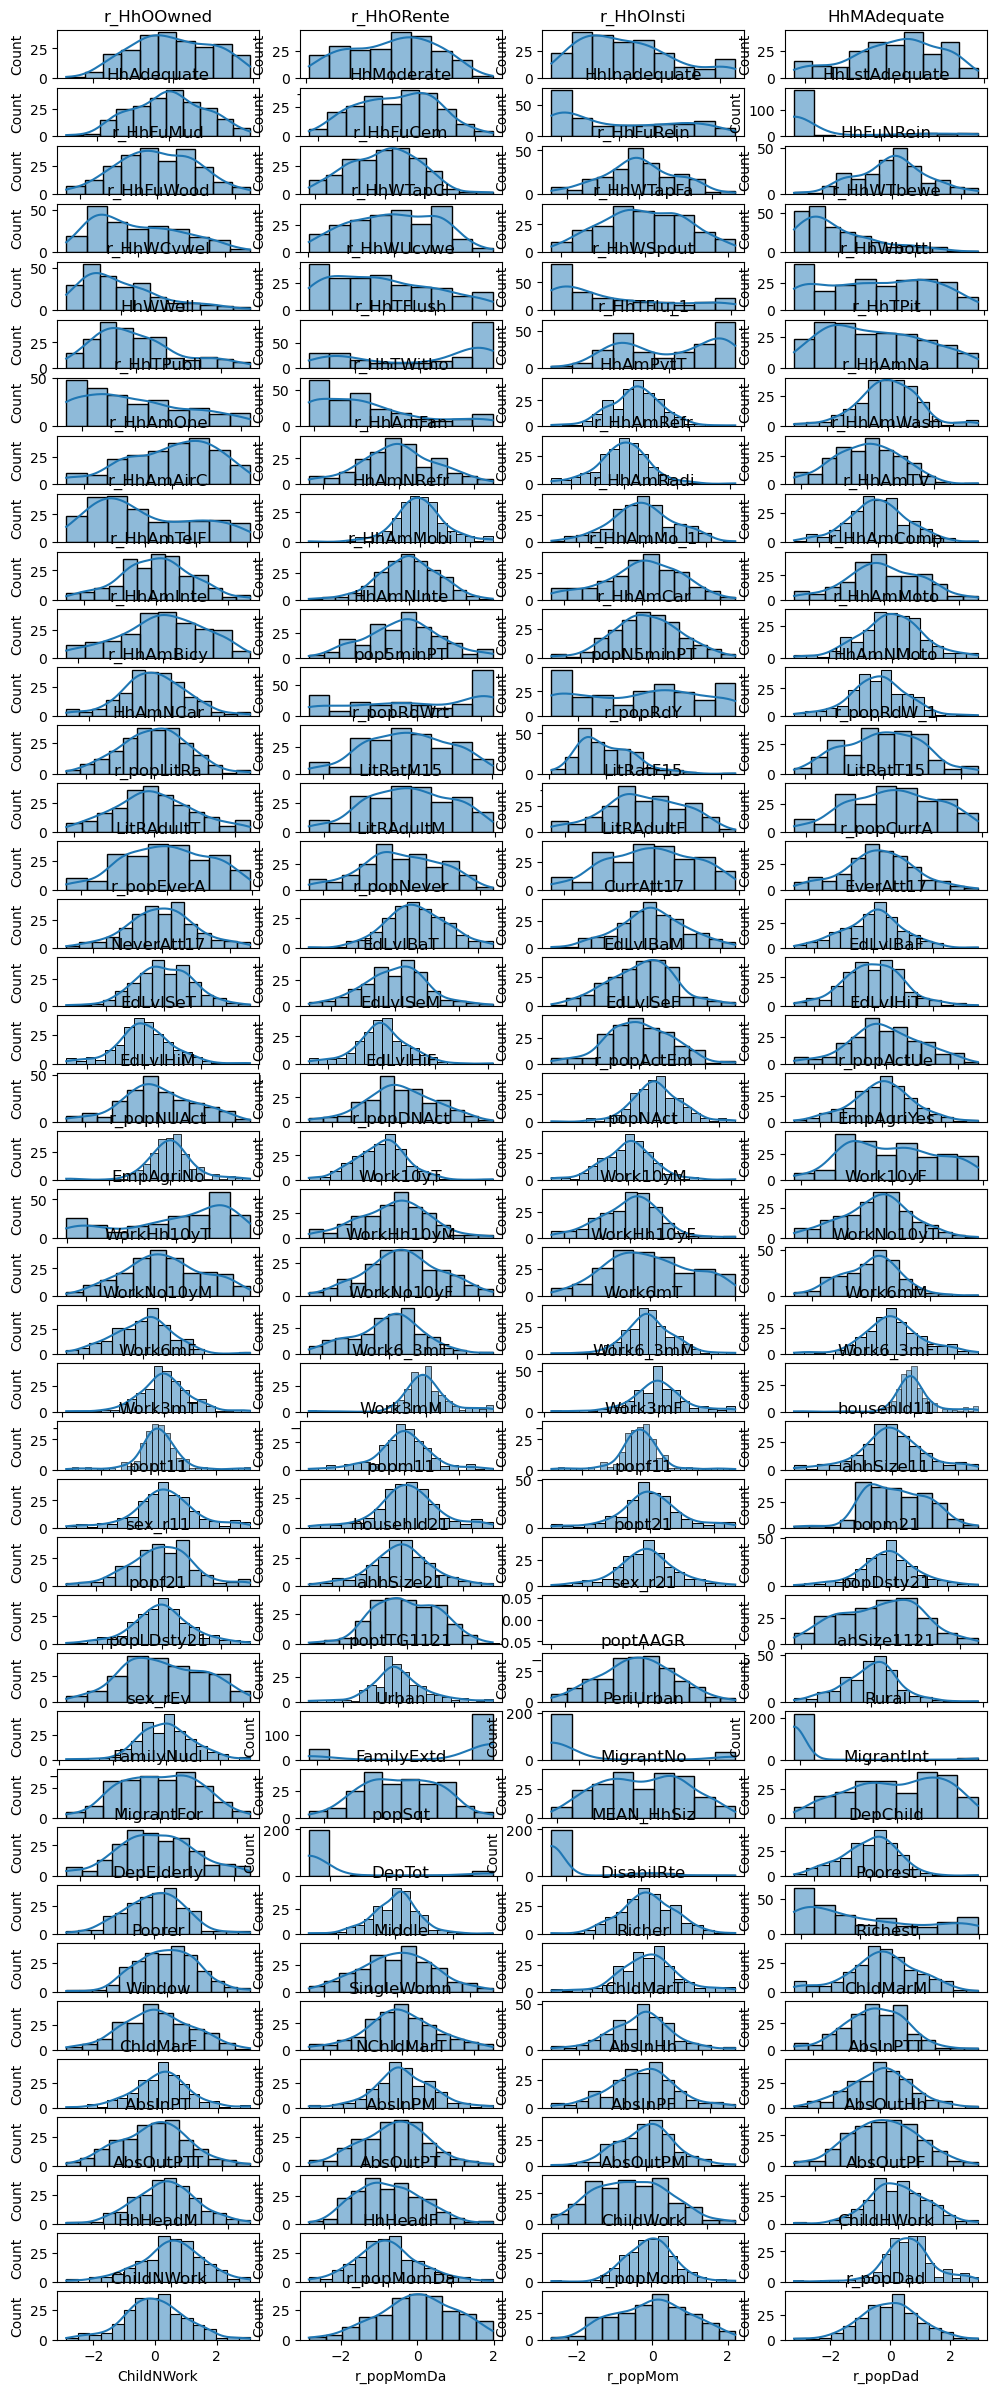

In [15]:
# Visualize distributions of normalised and standardised indicators
plt.figure(figsize=(12, 30))
for i, column in enumerate(data_standardized.columns):
    plt.subplot(40, 4, i + 1)
    sns.histplot(data_standardized[column].dropna(), kde=True)
    plt.title(column)
plt.tight_layout()
plt.show()

In [ ]:
display(HTML(data_standardized.to_html()))

In [20]:
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

# KMO Test
#kmo_all, kmo_model = calculate_kmo(data_standardized)
kmo_all, kmo_model = calculate_kmo(clean_data_standardized)
print(f"KMO: {kmo_model}")

# Bartlett's Test
#chi_square_value, p_value = calculate_bartlett_sphericity(data_standardized)
chi_square_value, p_value = calculate_bartlett_sphericity(clean_data_standardized)
print(f"Bartlett's Test: Chi-Square = {chi_square_value}, p-value = {p_value}")


NameError: name 'clean_data_standardized' is not defined

### 3. Multicolliniarity 

Multicollinearity occurs when two or more variables in a dataset are highly correlated, meaning they provide redundant information. In Factor Analysis, multicollinearity can distort the results because the method assumes that the observed variables are capturing distinct underlying factors. When variables are highly correlated, they inflate the variance of estimated factor loadings, making it difficult to discern which variables are genuinely contributing to a given factor. This leads to unstable and unreliable factor extraction. Addressing multicollinearity, typically by removing or combining correlated variables, is crucial for meaningful and interpretable results in factor analysis.

#### Variance Inflation Factor (VIF)
Is a statistical measure used to quantify how much the variance of an estimated regression coefficient increases when your predictors are correlated. It is particularly useful in regression analysis to detect multicollinearity, which can affect the performance of your model.
When performing factor analysis, the goal is to extract factors that adequately represent the data. High multicollinearity can cause certain factors to dominate the analysis, which can lead to misleading interpretations.
Removing or addressing variables with high VIFs can lead to a more accurate and interpretable factor structure.

Interpretation:

A VIF value of 1 indicates that there is no correlation between the 𝑖 𝑡ℎ variable and the others.
A VIF value between 1 and 5 suggests moderate correlation and is generally acceptable.
A VIF value greater than 5 (or some use a threshold of 10) indicates high multicollinearity, suggesting that the variable might be redundant or that the model may not perform well.

In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Check the shape of the dataset
print("Initial shape of dataset:", clean_data_standardized.shape)

# Step 1: Check for constant columns
constant_columns = clean_data_standardized.columns[clean_data_standardized.nunique() <= 1]
print("Constant columns:")
print(constant_columns)

# Step 2: Check for duplicated rows
duplicated_rows = clean_data_standardized[clean_data_standardized.duplicated()]
print("Duplicated rows count:", duplicated_rows.shape[0])

# Step 3: Standardize the data if not done properly
scaler = StandardScaler()
clean_data_standardized = pd.DataFrame(scaler.fit_transform(clean_data_standardized), columns=clean_data_standardized.columns)

# Re-check the shape of the standardized data
print("Shape of standardized data after scaling:", clean_data_standardized.shape)

# Step 4: Drop constant columns
data_vif = clean_data_standardized.drop(columns=constant_columns)

# Step 5: Calculate VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Calculate and display VIF
vif_df = calculate_vif(data_vif)

# Sort the VIF DataFrame in descending order by the VIF values
vif_df_sorted = vif_df.sort_values(by="VIF", ascending=False)

# Display the sorted DataFrame as HTML
display(HTML(vif_df_sorted.to_html()))


Initial shape of dataset: (230, 88)
Constant columns:
Index([], dtype='object')
Duplicated rows count: 0
Shape of standardized data after scaling: (230, 88)


#### Create a new dataframe with filtered variables

In [24]:
# JUMP THIS STEP IF IS THE FIRST TIME YOU RUN THIS CUNK
# Clean dataframe and store it in this list until mullticolliniarity decreases 
clean = [
'r_HhORente', # 'r_HhOOwned', 'r_HhOInsti',  # Ownership
'HhMAdequate', 'HhAdequate', 'HhModerate', 'HhInadequate', 'HhLstAdequate',  # Quality of House
'r_HhFuMud', 'r_HhFuCem', 'r_HhFuRein', 'r_HhFuWood', 'HhFuNRein', # House foundation material
'r_HhWTapCl', 'r_HhWTapFa',  'r_HhWbottl',  'r_HhWTbewe', 'r_HhWCvwel', 'r_HhWUcvwe', 'r_HhWSpout',#'HhWWell', # Drinking water
'r_HhTFlush', 'r_HhTFlu_1', 'r_HhTPit', 'r_HhTPubli', 'r_HhTWitho', #'HhAmPvtT',  # Toilet
'r_HhAmNa', 'r_HhAmRefr', 'r_HhAmAirC','HhAmNRefr',  # 'r_HhAmWash','r_HhAmFan','r_HhAmOne', Amenities Comfort
'r_HhAmRadi', 'r_HhAmTV', 'r_HhAmMobi', 'r_HhAmInte', 'HhAmNInte',# 'r_HhAmTelF', 'r_HhAmMo_1', 'r_HhAmComp', # Communication
'r_HhAmCar', 'r_HhAmMoto', 'pop5minPT', 'popN5minPT','HhAmNMoto', 'HhAmNCar',# 'r_HhAmBicy',  # Transport
    
'r_popRdW_1', #'r_popRdWrt', 'r_popRdY',  #  # Literacy pop > 5 y/o
#'LitRatM15', 'LitRatF15', 'LitRatT15',  # Literacy youth pop < 15 y/o
'LitRAdultT', #'LitRAdultM', 'LitRAdultF',  # Literacy adult pop >= 15 y/o
'r_popCurrA',  'r_popNever',   #'r_popEverA', School Attendance Pop 5 to 25 y/o
#'CurrAtt17', 'EverAtt17', 'NeverAtt17',  # School Attendance Pop 5 to 17 y/o
'EdLvlBaT','EdLvlSeT','EdLvlHiT', # 'EdLvlSeM', 'EdLvlSeF','EdLvlBaM', 'EdLvlBaF',   'EdLvlHiM', 'EdLvlHiF',  # Educational attainment

'popNAct',#'r_popActEm', #'r_popActUe', 'r_popNUAct', 'r_popDNAct',  # Economic activity Pop 10+ y/o
'EmpAgriYes', 'EmpAgriNo',  # Agricole employment
'WorkHh10yT','WorkNo10yM', 'WorkNo10yF', 'WorkNo10yT',  'Work10yM', 'Work10yF', #'WorkHh10yF', 'WorkHh10yM',  'Work10yT', Employment sector and sex
'Work3mM', 'Work3mF',  # 'Work3mT', 'Work6mT', 'Work6mM', 'Work6mF', 'Work6_3mT', 'Work6_3mM', 'Work6_3mF', Economic work within last 12 months

#'househld11', 'popt11', 'popm11', 'popf11', 'ahhSize11', 'sex_r11',  # 2011 Demographic Data
#'househld21', 'popt21', 'popm21', 'popf21',  'sex_r21',  # 2021 Demographic Data
'popDsty21', 'popLDsty21','poptTG1121', 'poptAAGR', 'ahSize1121','ahhSize21', 'sex_rEv', #'sex_r21',  # Pop density and growth
#'Urban', 'PeriUrban', 'Rural',  # Urbanisation status
'FamilyExtd',  # 'FamilyNucl', Family structure
'MigrantInt', 'MigrantFor',   # 'MigrantNo', Migration status
'popSqt', #'MEAN_HhSiz',  # Informal settlement population
'DepChild', 'DepElderly', # 'DepTot',  # Dependency
'DisabilRte',  # Disability rate
'Poorest', 'Poorer', 'Middle', 'Richer', 'Richest',  # Wealth Quintile
'Window', #'SingleWomn',  # Widow and Single Woman status
'ChldMarM', 'ChldMarF', 'NChldMarT', # 'ChldMarT',Child Marriage
'AbsInPTT', 'AbsOutPM', 'AbsOutPF',  # 'AbsInPM', 'AbsInPF', 'AbsInHh',  'AbsInPT', 'AbsOutHh', 'AbsOutPTT', 'AbsOutPT', Absent household members
'HhHeadF', # 'HhHeadM', Head of household
'ChildWork', 'ChildHWork', 'ChildNWork',  # Child labor 10 - 17 y/o
'r_popMom', #'r_popDad',# 'r_popMomDa', 'r_popDadSM', 'r_popMomSD', 
'r_popOther', 'r_popEmplo'  # Living with minor status
]
""""clean = [ 'poptAAGR', 'sex_rEv', 'popDsty21','AbsInHh','Window','SingleWomn',#'munward','AbsInPF','AbsInPM',
        'DepChild','DepElderly','DepTot','DisabilRte','FamilyExtd',#'FamilyNucl','AbsInPT',  # Demographics
        'Poorest','Poorer', 'Middle','Richer', 'Richest', #Wealth quintiles
        'Rural', 'PeriUrban', 'Urban', 
        'popMom','ChildHWork','ChildNWork','ChildWork','ChldMarF','ChldMarM', #'ChldMarT','popDad', 'popMomDa',  # Child vulnerability
        'HhORente', 'ahhSize21','HhAdequate','HhMAdequate','HhModerate','HhInadequate','HhLstAdequate',  # Ownership and hh size
        'popNAct','EmpAgriYes',#'popNUAct', 'popDNAct','popActEm', 'popRdW_1','EmpAgriNo',  # economic activity
        'popCurrA','popLitRa', 'CurrAtt17', 'NeverAtt17',# 'EdLvlBaF','popEverA','EverAtt17',  # education level
        'EdLvlBaM', 'EdLvlHiT','EdLvlSeF','EdLvlSeM',#'EdLvlHiF','EdLvlHiM','EdLvlBaT','EdLvlSeT', # education level
        'LitRatT15',#'LitRatF15','LitRatM15', #'popRdY', 'popNever', # education level
        'HhTPit',  'HhTFlu_1', #'HhTWitho',
        'HhFuRein', 'HhFuMud', 'HhFuWood', #'HhFuCem',
        'HhWTbewe', 'HhWWell', 'HhWTapFa', #'HhWSpout',  # acces to drinking water
        'HhAmNa', # no amenities
        'HhAmTV', 'HhAmInte',  #'HhAmTelF','HhAmMobi','HhAmNInte', # acces to comunication
        'pop5minPT',  'HhAmPvtT', 'HhAmNMoto', 'HhAmNCar',#'popN5minPT', # access to transport
        'HhAmNRefr', 'HhAmWash', 'HhAmAirC' # 'HhAmFan', 'HhAmRefr', access to confort
       ]"""

clean_data_standardized = data_standardized[clean]
clean_data = fa_data[clean]

In [25]:
df_final_nonst = pd.concat([df[['munward', 'poptAAGR']], clean_data], axis=1)

In [26]:
df_final_nonst.to_csv(r"C:\GIS\G8\Kathmandu\scripts\not_standardized_census_data.csv", index=False)

In [21]:
display(HTML(clean_data_standardized.to_html()))

#### Correlation matrix
Factor analysis inherently assumes that the variables are correlated to some extent. We will examine the correlation matrix and look for significant correlations among the variables. High correlations (> 0,8 or <-0,8) suggest that the variables may be measuring similar constructs. Exclude correlated variables depending if their multicollinearity is high (one with multiple variables). Keep variables that are less correlated or that are meningful theoretically 

In [ ]:
import seaborn as sns

plt.figure(figsize=(24, 18))
#correlation_matrix = data_standardized.corr()
correlation_matrix = clean_data_standardized.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()


In [ ]:
# Convert the matrix to a long-form DataFrame with pairs
corr_pairs = (
    correlation_matrix
    #.abs()  # Use absolute value to check magnitude of correlation
    .unstack()  # Convert to long format
    .reset_index()  # Reset index to make it a DataFrame
    .rename(columns={0: 'correlation'})  # Rename the correlation column
)

# Filter out self-correlations (where both columns are the same)
corr_pairs = corr_pairs[corr_pairs['level_0'] != corr_pairs['level_1']]

# Sort by correlation value in descending order
sorted_corr_pairs = corr_pairs.sort_values(by='correlation', ascending=False)

# Display the top correlated pairs
display(HTML(sorted_corr_pairs.to_html()))


#### Apply Bartlett’s Test of Sphericity for a second time on the cleaned data

#### 1. Kaiser-Meyer-Olkin (KMO) Test:
The KMO test measures how well your variables are suited for factor analysis by examining the proportion of variance among the variables that might be common variance (shared variance) versus unique variance (individual to each variable).
Interpretation of the KMO score:
Values closer to 1 indicate that factor analysis is appropriate. The following scale is commonly used for KMO interpretation:
- KMO > 0.90: Marvelous
- KMO 0.80–0.89: Meritorious
- KMO 0.70–0.79: Middling
- KMO 0.60–0.69: Mediocre
- KMO 0.50–0.59: Miserable
- KMO < 0.50: Unacceptable

##### 2. Bartlett’s Test of Sphericity:
Bartlett's test examines whether the correlation matrix of the variables is significantly different from an identity matrix (i.e., one where all off-diagonal correlations are zero).
Hypotheses for Bartlett's test:
Null Hypothesis (H₀): The variables are not correlated, and thus factor analysis is not appropriate.
Alternative Hypothesis (H₁): The variables are correlated, making factor analysis appropriate.
Interpretation:
A significant p-value (typically < 0.05) suggests that the variables are correlated enough to proceed with factor analysis.

In [ ]:
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

scaler = StandardScaler()
clean_data_standardized = pd.DataFrame(scaler.fit_transform(clean_data_standardized), columns=clean_data_standardized.columns)

# KMO Test
kmo_all, kmo_model = calculate_kmo(clean_data_standardized)
print(f"KMO: {kmo_model}")

# Bartlett's Test
chi_square_value, p_value = calculate_bartlett_sphericity(clean_data_standardized)
print(f"Bartlett's Test: Chi-Square = {chi_square_value}, p-value = {p_value}")

It is possible that you got a warning message from the codechunk above: "The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero."

This warning indicates that the variance-covariance matrix may be singular or nearly singular, which can occur if there are redundant variables or multicollinearity present in your dataset. It suggests that while the calculations were completed, they may not be stable or reliable.

### C. Conduct Factor Analysis
Decide how many factors to extract (you can adjust n_factors based on your analysis).

#### Eigenvalues
Definition: Eigenvalues represent the amount of variance accounted for by each factor or principal component. Each eigenvalue corresponds to a factor or component extracted from the dataset.

Interpretation:

Magnitude: Higher eigenvalues indicate that a factor explains a larger portion of the variance in the data. Typically, an eigenvalue greater than 1 is considered significant in PCA (Kaiser criterion), as it implies that the factor explains more variance than a single observed variable.
Cumulative Eigenvalues: You can also look at cumulative eigenvalues to see how much total variance is explained by a specific number of factors. For example, if the first two factors have cumulative eigenvalues that account for 70% of the total variance, you might decide to retain those two factors.

##### Scree Plot
Definition: A scree plot is a graphical representation of eigenvalues against the number of factors (or components). It typically shows a decreasing trend as you add more factors.

Interpretation:

Identifying the "Elbow": The key part of the scree plot is to look for a point where the slope of the curve changes significantly, known as the "elbow." This point suggests the optimal number of factors to retain. Factors after the elbow contribute less to the overall variance.
Above the Elbow: Retain these factors as they contribute meaningfully to the explained variance.
Below the Elbow: These factors usually account for a small amount of variance and may be considered noise or redundancy.

Eigenvalues:
[2.67362259e+01 8.46943411e+00 5.52562352e+00 4.12898426e+00
 2.76723532e+00 2.41460187e+00 1.92062001e+00 1.66583824e+00
 1.40560348e+00 1.34332356e+00 1.26604934e+00 1.13220381e+00
 1.08116982e+00 9.62885760e-01 9.45715624e-01 8.94652653e-01
 8.33451157e-01 7.26504750e-01 6.94901442e-01 6.68165684e-01
 6.26840284e-01 5.98151037e-01 5.50330450e-01 5.35635048e-01
 5.12005409e-01 4.93397762e-01 4.51693778e-01 4.34635172e-01
 4.03007215e-01 3.60533443e-01 3.55153883e-01 3.44079565e-01
 3.18678157e-01 3.01994075e-01 2.60830963e-01 2.46370644e-01
 2.41461033e-01 2.33695534e-01 2.30844216e-01 2.16824236e-01
 2.10649693e-01 1.95182016e-01 1.80584797e-01 1.63967632e-01
 1.60367952e-01 1.56453595e-01 1.50630158e-01 1.31362489e-01
 1.22145327e-01 1.19486818e-01 1.03183638e-01 8.92295375e-02
 8.17441440e-02 7.58397632e-02 6.99349828e-02 6.68196732e-02
 6.45074093e-02 6.17827039e-02 5.45264294e-02 4.95494251e-02
 4.65672715e-02 4.56145254e-02 4.15720165e-02 3.56612594e-02
 3.20602785

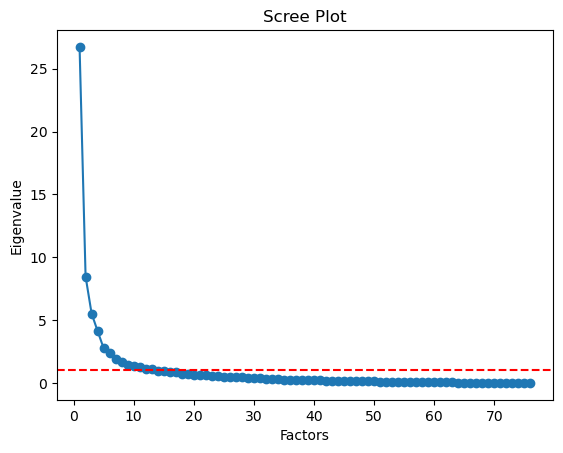

In [37]:

# Create a factor analysis object
fa = FactorAnalyzer(n_factors=4, rotation='varimax')
fa.fit(clean_data_standardized)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
print("Eigenvalues:")
print(ev)

# Plot the eigenvalues
import matplotlib.pyplot as plt

plt.scatter(range(1, clean_data_standardized.shape[1] + 1), ev)
plt.plot(range(1, clean_data_standardized.shape[1] + 1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='--')
plt.show()


Interpret Factor Loadings
Extract and display the factor loadings to interpret which variables load onto which factors.

#### What Are Factor Loadings?
Definition: Factor loadings represent the correlation between observed variables and the latent factors derived from factor analysis. Each loading indicates how much of the variance in the variable is explained by the factor.

Range: Factor loadings range from -1 to 1. A loading closer to 1 or -1 suggests a strong relationship, while a loading close to 0 suggests a weak relationship.

#### Interpreting Factor Loadings
Magnitude of Loadings:

**Strong Loadings:** Generally, loadings above ±0.30 are considered significant, and those above ±0.40 or ±0.50 indicate a strong relationship with the factor.
Weak Loadings: Loadings closer to 0 suggest that the variable has little to no contribution to the factor.
Direction of Loadings:

**Positive Loadings:** A positive loading indicates that as the factor increases, the variable tends to increase as well. For example, if a variable measuring income has a loading of +0.70 on a "socioeconomic status" factor, it suggests that higher socioeconomic status is associated with higher income.
Negative Loadings: A negative loading indicates an inverse relationship. For instance, if a variable measuring debt has a loading of -0.60 on the same factor, it suggests that as socioeconomic status increases, debt tends to decrease.
Identifying Factor Structure:

**Grouping Variables:** Look for variables that load highly on the same factor to identify patterns. Variables that share a similar high loading on a factor can be interpreted as measuring a common underlying construct.
Factor Naming: Based on the variables that load highly on a factor, you can assign a meaningful name to that factor. For instance, if a factor has high loadings from variables like "income," "education level," and "employment status," you might name it "Economic Status."

**Rotation Methods:** If you applied rotation (e.g., Varimax or Promax), the factor loadings will be easier to interpret. Rotated factors tend to have higher loadings for a smaller number of variables and lower loadings for others, enhancing clarity in understanding the factor structure.
Cross-loadings:

**Multiple High Loadings:** If a variable has significant loadings on multiple factors (e.g., both +0.40 on Factor 1 and +0.35 on Factor 2), this may indicate that the variable is related to more than one construct, which can complicate interpretation.
Resolving Cross-loadings: Consider the theoretical context or domain knowledge to determine which factor is more relevant for that variable.

In [38]:
# Get factor loadings
loadings = fa.loadings_
loadings_df = pd.DataFrame(loadings, columns=[f'F_{i+1}' for i in range(loadings.shape[1])], index=clean_data_standardized.columns)

print("Factor Loadings:")
print(loadings_df)

# Save loadings to a CSV file
loadings_df.to_csv('factor_loadings_new_4F_22-10.csv')


Factor Loadings:
                   F_1       F_2       F_3       F_4
r_HhORente   -0.741171  0.594290 -0.108301 -0.168917
HhMAdequate  -0.642226  0.620122  0.215722 -0.140509
HhAdequate    0.375574 -0.675208 -0.145536  0.218788
HhModerate    0.822763 -0.417505 -0.141433  0.086556
HhInadequate  0.888008 -0.152188 -0.096722 -0.001636
...                ...       ...       ...       ...
ChildHWork    0.324982 -0.231484 -0.146297  0.288131
ChildNWork    0.014636  0.220667  0.178730 -0.466644
r_popMom      0.173926  0.682443 -0.100052  0.283181
r_popOther   -0.325480  0.631948 -0.127946 -0.260160
r_popEmplo   -0.553456  0.068808  0.158979 -0.155421

[76 rows x 4 columns]


In **Factor Analysis (FA)**, the term "scores" refers to the **factor scores**, which represent the values of the latent factors for each observation in the dataset. Factor analysis seeks to identify underlying variables (called **factors**) that explain the patterns of correlations within the observed variables. Here’s a breakdown of the key concepts:

### 1. **Factors**:
   - Factors are unobservable, latent variables that are thought to influence the observed variables. 
   - Each observed variable can be modeled as a linear combination of these factors plus some error.
   - The factors reduce the dimensionality of the data by summarizing the common variance among the observed variables.

### 2. **Factor Scores**:
   - Factor scores are the values that represent each observation’s placement on the underlying latent factors.
   - If you have several factors (e.g., Factor 1, Factor 2), each observation will have a factor score for each of these latent variables.
   - These scores essentially tell you how much of each factor is present in each observation.

### 3. **How Factor Scores are Computed**:
   Factor scores are typically estimated after extracting the factors. There are several methods for calculating them:
   - **Regression Method**: Predicts factor scores by regressing the observed variables on the estimated factor loadings.
   - **Bartlett Method**: Minimizes the unique variances to provide more accurate scores when the model is a good fit.
   - **Thomson Method**: Also known as the "least squares method", it emphasizes factor scores' variance.
   
### 4. **Usage of Factor Scores**:
   - **Interpretation**: Factor scores provide insights into how each observation relates to the factors. For instance, if a factor represents "socioeconomic status," higher factor scores would indicate higher socioeconomic status for certain individuals.
   - **Subsequent Analysis**: Factor scores can be used in other analyses, such as regression, clustering, or predictive models.

### Example:
In a dataset with five observed variables (e.g., income, education, job satisfaction, etc.), after factor analysis, you might identify two factors: "Socioeconomic Status" and "Job Satisfaction." Each individual in your dataset will have a factor score for "Socioeconomic Status" and another for "Job Satisfaction," representing their underlying level on these factors.

Factor scores allow for dimensional reduction while retaining essential information about each observation with respect to the latent factors.

In [40]:
# Calculate factor scores using factor analyzer's method
factor_scores = fa.transform(clean_data_standardized)

# Convert factor scores into a DataFrame
factor_scores_df = pd.DataFrame(factor_scores, columns=[f'F_{i+1}' for i in range(factor_scores.shape[1])])

# Ensure the index of the factor scores matches the original data for merging
factor_scores_df['munward'] = df['munward']


In [1]:
# Merge factor scores with the original dataset on OBJECTID
final_df = pd.merge(df, factor_scores_df, on='munward')

# Verify the merged DataFrame
print(final_df.head())

# Save the final dataset with factor scores
final_df.to_excel('data_with_factor_scores_new_4F_22-10.xlsx', index=False)


NameError: name 'pd' is not defined

# Principal Components Analysis (PCA) 
## Build a Composite Index assigning Weigths to Variables and Constructs 

Inspired by: https://github.com/elifaslanbulut/Economic-Distress-Index-county-level-/blob/main/notebooks/create-economic-distress-index-layer.ipynb

To determine index weight for each component we will use **Principal Component Analysis**. PCA explains the variance of index components through the concept of principal components. In PCA, the original variables are transformed into a new set of uncorrelated variables called principal components. These components are ranked in order of the amount of variance they explain in the data. The first principal component captures the most significant amount of variance, the second component captures the second most significant amount of variance, and so on. The explained variance ratio is a measure of the proportion of the total variance in the data that is accounted for by each principal component. It helps in understanding the relative importance of each component in explaining the overall variance. Higher explained variance ratios suggest that a component has a more significant impact on the overall variance and should be considered more important when determining the weights for the index components

### 1. Build dataframes of each construct retrived by Factor Analysis in the first half of this notebook 
I recommend opening the CSV file and retaining the variables that load more than 0.3 on each factor. These variables will serve as the indicators for your new index. Reflect on the underlying meaning of these indicators and how they relate to one another. Name the factors based on the context and theoretical background of your research.

In [41]:
# 1) Rural multidimentional poverty index

rural = [ 
         'HhLstAdequate', 'HhInadequate', 'HhModerate','r_HhFuWood', 'r_HhFuMud',
         'Poorest', 'Poorer', 'Middle',
         'EmpAgriYes', 'WorkHh10yT', 
         'DepChild', 'ChldMarF', 'ChldMarM', 'ChildHWork','sex_rEv', 'DisabilRte',
         'r_popRdW_1','EdLvlBaT',
         'r_HhTPit','r_HhTFlu_1','r_HhTWitho',
         'r_HhWSpout','r_HhWTapFa', 
         'popLDsty21',  'ahhSize21', 
         'popN5minPT','HhAmNInte', 'r_HhAmNa']

rural_data = clean_data_standardized[rural]

In [44]:
# 2) Urban Transition Index: urban expanion and population growth with Female-Headed Households and Child Dependency

trans = [
         'MigrantInt', 'AbsOutPM', 'AbsInPTT',
         'WorkNo10yT',
         'EdLvlSeT',
         'poptAAGR', 'r_popMom', 'HhHeadF', 'sex_rEv',
         'DepChild',
         'HhMAdequate', 'r_HhORente', 'r_HhFuRein', 'ahhSize21',
         'r_HhAmInte', 
         'r_HhWbottl', 'r_HhWTbewe', 'r_HhWCvwel',
         'Richer' ]

trans_data = clean_data_standardized[trans]

In [53]:
# 3) Urban high class index: high quality housing, acces to private and public transport, information, education and well being amenities  

high = [
        'Richest', 'HhMAdequate', 'MigrantFor',
        'r_popCurrA','EdLvlHiT','LitRAdultT',
        'r_HhAmRefr','r_HhAmAirC','r_HhAmTV', 'r_HhAmInte',
        'r_HhAmMoto', 'r_HhAmCar', 
        'NChldMarT']

high_data = clean_data_standardized[high]

In [55]:
# 4) Urban multidimentional poverty index
urban = [ 
         'HhLstAdequate', 'HhInadequate', 'HhModerate', 'r_HhFuMud', 'HhFuNRein','r_HhORente',
         'Poorest', 'Poorer', 'Middle',
         'EmpAgriNo', 
         'DepChild', 'ChldMarF', 'ChldMarM', 'ChildHWork', 'DisabilRte',
         'r_popRdW_1','EdLvlBaT',
         'r_HhTPit','r_HhTWitho',
         'popDsty21',  'ahhSize21', 
         'HhAmNMoto', 'HhAmNCar',
         'HhAmNInte', 'HhAmNRefr',
        ]

urban_data = clean_data_standardized[urban]

### 2. Scale the data  (iterate this step for each construct)
Ensure Factors are Equally Scaled as their respective ranges vary. To calculate our composite index we are going to need to rescale these columns.
In this case, we are keeping it simple by using the MinMaxScaler from SciKit-Learn. Depending on the characteristics of the data you are using, there are a large variety of other ways to scale data.

In [119]:
# THIS IS THE MOMENT TO ASIGN EACH CONSTRUCT AS DF !!!!
dfpca = urban_data.copy()
dfpca.describe().loc[['min', 'max']]

HhLstAdequate  HhInadequate  HhModerate  r_HhFuMud  HhFuNRein  \
min      -0.504930     -1.158514   -2.242084  -2.349120  -2.843515   
max       2.665485      1.991063    2.438289   2.389243   2.485606   

     r_HhORente   Poorest    Poorer    Middle  EmpAgriNo  ...  r_popRdW_1  \
min   -1.938993 -1.116769 -3.379093 -2.423824  -2.017546  ...   -2.273993   
max    2.333834  1.987920  2.778029  2.607266   1.354366  ...    2.441751   

     EdLvlBaT  r_HhTPit  r_HhTWitho  popDsty21  ahhSize21  HhAmNMoto  \
min -2.691774 -1.674420   -1.089847  -2.170646  -3.052225  -2.888959   
max  3.038732  2.129197    2.376885   2.445505   2.684304   3.422595   

     HhAmNCar  HhAmNInte  HhAmNRefr  
min -2.590941  -2.536929  -4.365375  
max  2.841959   2.411308   2.878067  

[2 rows x 25 columns]

In [120]:
dfpca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HhLstAdequate  230 non-null    float64
 1   HhInadequate   230 non-null    float64
 2   HhModerate     230 non-null    float64
 3   r_HhFuMud      230 non-null    float64
 4   HhFuNRein      230 non-null    float64
 5   r_HhORente     230 non-null    float64
 6   Poorest        230 non-null    float64
 7   Poorer         230 non-null    float64
 8   Middle         230 non-null    float64
 9   EmpAgriNo      230 non-null    float64
 10  DepChild       230 non-null    float64
 11  ChldMarF       230 non-null    float64
 12  ChldMarM       230 non-null    float64
 13  ChildHWork     230 non-null    float64
 14  DisabilRte     230 non-null    float64
 15  r_popRdW_1     230 non-null    float64
 16  EdLvlBaT       230 non-null    float64
 17  r_HhTPit       230 non-null    float64
 18  r_HhTWitho

In [121]:
# Identify the quantitative columns to scale
quant_cols = [col for col in dfpca.columns if dfpca[col].dtype in ['int64', 'float64']]

# List of qualitative (non-quantitative) columns
qual_cols = [col for col in dfpca.columns if col not in quant_cols]

# create an instance of the min-max scaler
min_max_trs = MinMaxScaler(feature_range=(0, 1))
# transform the data - since it returns a numpy array, convert back into data frame
dfpca_scaled = pd.DataFrame(min_max_trs.fit_transform(dfpca[quant_cols]), columns=quant_cols)

# combine the non-scalar columns back onto the data frame again
#dfpca_scaled = pd.merge(dfpca[qual_cols], dfpca_scaled, left_index=True, right_index=True)

# report minimum and maximums for comparison
dfpca_scaled.describe().loc[['min', 'max']]

HhLstAdequate  HhInadequate  HhModerate  r_HhFuMud  HhFuNRein  \
min            0.0           0.0         0.0        0.0        0.0   
max            1.0           1.0         1.0        1.0        1.0   

     r_HhORente  Poorest  Poorer  Middle  EmpAgriNo  ...  r_popRdW_1  \
min         0.0      0.0     0.0     0.0        0.0  ...         0.0   
max         1.0      1.0     1.0     1.0        1.0  ...         1.0   

     EdLvlBaT  r_HhTPit  r_HhTWitho  popDsty21  ahhSize21  HhAmNMoto  \
min       0.0       0.0         0.0        0.0        0.0        0.0   
max       1.0       1.0         1.0        1.0        1.0        1.0   

     HhAmNCar  HhAmNInte  HhAmNRefr  
min       0.0        0.0        0.0  
max       1.0        1.0        1.0  

[2 rows x 25 columns]

In [122]:
#Prepare the data to conduct principal component analysis

variables = dfpca_scaled

variables

HhLstAdequate  HhInadequate  HhModerate  r_HhFuMud  HhFuNRein  \
0         0.000000      0.378407    0.706747   0.806883   0.722454   
1         0.000000      0.654180    1.000000   0.994835   1.000000   
2         0.000000      0.756411    0.831837   0.775358   0.799092   
3         0.681171      0.847384    0.777751   0.688991   0.744273   
4         0.892795      0.838533    0.612180   0.668493   0.679610   
..             ...           ...         ...        ...        ...   
225       0.000000      0.915662    0.703104   0.590033   0.658335   
226       0.000000      0.645430    0.732779   0.678010   0.758006   
227       0.000000      0.806748    0.642801   0.602807   0.549692   
228       0.371207      0.342355    0.541126   0.396656   0.453220   
229       0.000000      0.095677    0.325901   0.145563   0.210190   

     r_HhORente   Poorest    Poorer    Middle  EmpAgriNo  ...  r_popRdW_1  \
0      0.095105  0.865030  0.733776  0.773612   0.459574  ...    0.589948   
1      0.020477  0.987038  0.982210  0.977597   0.022148  ...    1.000000   
2      0.093480  0.961000  0.801079  0.764881   0.086877  ...    0.695244   
3      0.207051  0.818298  0.761419  0.896000   0.408211  ...    0.540791   
4      0.314453  0.498510  0.679726  0.668482   0.409449  ...    0.698177   
..          ...       ...       ...       ...        ...  ...         ...   
225    0.133633  0.932360  0.723397  0.687498   0.062469  ...    0.717096   
226    0.105115  0.837386  0.744751  0.674860   0.213192  ...    0.742406   
227    0.180382  0.626772  0.710360  0.537856   0.125632  ...    0.710467   
228    0.434148  0.284985  0.545343  0.524475   0.595796  ...    0.550113   
229    0.507757  0.097440  0.344030  0.334869   0.628197  ...    0.383691   

     EdLvlBaT  r_HhTPit  r_HhTWitho  popDsty21  ahhSize21  HhAmNMoto  \
0    0.715722  0.484505    0.576288   0.168858   0.827956   0.351450   
1    0.858728  0.088005    0.832311   0.061748   0.779743   0.825079   
2    0.645640  0.900204    0.371476   0.165115   0.608683   0.362857   
3    0.663917  0.770237    0.523979   0.293488   0.665766   0.665138   
4    0.569976  0.421802    0.547917   0.407753   0.717808   0.517792   
..        ...       ...         ...        ...        ...        ...   
225  0.545586  0.878890    0.703714   0.151722   0.687828   0.366399   
226  0.513517  0.981848    0.666196   0.312747   0.903182   0.400676   
227  0.379209  0.569539    0.782998   0.285539   0.795644   0.223432   
228  0.584021  0.315082    0.297178   0.509253   0.534235   0.527776   
229  0.428271  0.188864    0.190631   0.555365   0.574271   0.425443   

     HhAmNCar  HhAmNInte  HhAmNRefr  
0    0.622322   0.780375   0.707439  
1    0.836586   0.953174   0.952395  
2    0.703108   0.724088   0.623192  
3    0.671567   0.697305   0.768788  
4    0.572144   0.701882   0.698419  
..        ...        ...        ...  
225  0.686886   0.796351   0.685558  
226  0.411623   0.715516   0.627337  
227  0.404574   0.678387   0.528110  
228  0.439942   0.521252   0.605229  
229  0.433023   0.277114   0.581162  

[230 rows x 25 columns]

### 3. Standardize the Data
Before applying PCA, we need to standardize each indicator so that they all contribute equally (given they may have different scales). We use z-score normalization (mean = 0, standard deviation = 1) to achieve this.

In [123]:
# Initialize StandardScaler for normalization
scaler = StandardScaler()
normalized_data = scaler.fit_transform(variables)

### 4. Apply PCA to Each Construct
Here we run PCA on each of the constructs independently to extract the principal components and their corresponding loadings. This will help identify how much each indicator within a dimension contributes to the overall variance.

For each dimension:

Run PCA on the standardized indicators.
- Identify the explained variance for each component. You may want to use only the first principal component (PC1) or a combination of components based on the explained variance (e.g., aim to retain components explaining 70-90% of the variance).
- The loadings of PC1 (or a weighted combination of components) will serve as the weights for each indicator.

In [124]:
n_components = 25  # Number of components to extract
pca = PCA(n_components=25)  # Set the desired number of components
pca.fit(normalized_data)

# Get the transformed data and explained variance ratios
##After running this code, you will get the transformed data in the transformed_data array, where each row represents an observation, and each column represents a principal component. 
###The explained variance ratios are stored in the explained_variance_ratios array, indicating the proportion of variance explained by each principal component.
transformed_data = pca.transform(normalized_data)
component_loadings = pca.components_
explained_variance_ratios = pca.explained_variance_ratio_

In [125]:
component_loadings

array([[ 8.78711498e-02,  2.27388365e-01,  2.51521817e-01,
         2.01904194e-01,  1.67709100e-01, -2.25293491e-01,
         2.47902661e-01,  2.49282330e-01,  2.48758035e-01,
        -2.40759952e-01,  1.78586952e-01,  2.08719526e-01,
         1.67720436e-01,  1.30953044e-01,  9.39839966e-02,
         2.49217047e-01,  2.35239478e-01,  1.74934584e-01,
         1.85248795e-01, -2.18455455e-01,  1.87373040e-01,
         9.22878718e-02,  1.78955438e-01,  2.28430675e-01,
         1.63489379e-01],
       [-3.91334578e-03, -9.59957241e-02, -1.39421118e-01,
        -1.72205975e-01, -4.84080025e-02,  3.13451666e-01,
        -1.07775011e-01, -1.07896882e-01, -6.17121601e-03,
         1.08687923e-01,  1.70308241e-01,  2.15258162e-01,
         1.28885126e-01, -3.99619726e-03,  8.19975556e-02,
         1.94961249e-02,  1.09191284e-01,  7.24226958e-02,
         6.45275436e-05,  1.54059256e-01, -3.25616067e-01,
         5.24017695e-01,  2.77805865e-01,  1.30456991e-01,
         4.37244998e-01],
    

### 5. Print the transformed data and explained variance ratios

In [126]:
print("Transformed Data:")
print(transformed_data)
print("\nExplained Variance Ratios:")
print(explained_variance_ratios)

Transformed Data:
[[ 4.67689014e+00 -8.09048655e-01  3.97688047e-01 ...  3.87967523e-01
  -1.21243288e-02 -1.00991310e-01]
 [ 9.06720305e+00  1.80315385e+00  2.30773277e-01 ... -8.89430364e-02
   6.81840871e-02 -3.28548692e-02]
 [ 5.20518402e+00 -1.21733667e+00 -1.32824016e+00 ... -3.17927493e-01
   3.30901657e-01 -6.49018455e-02]
 ...
 [ 3.13142974e+00 -2.32579729e+00  1.12450943e+00 ...  1.60585243e-02
  -1.41672551e-01 -5.88378633e-02]
 [ 7.47932634e-01  9.01666872e-01  1.70937912e+00 ... -8.16556128e-03
  -3.78770807e-02  1.77426188e-01]
 [-2.40370558e+00  3.99345651e-01  2.35685543e+00 ...  4.84682518e-02
  -6.45499939e-02  9.74167685e-02]]

Explained Variance Ratios:
[0.5308489  0.09580282 0.06598267 0.04633401 0.04291045 0.03420056
 0.02926577 0.02642142 0.01976248 0.01792179 0.01564882 0.01198592
 0.00953469 0.00914147 0.00690102 0.00651615 0.00573303 0.00494352
 0.00421923 0.00399186 0.00335441 0.00284568 0.00262165 0.00198794
 0.00112375]


### 6. Normalize component loadings and get weights for first and second principal component

In [127]:
weights = np.abs(component_loadings) / np.sum(np.abs(component_loadings), axis=1, keepdims=True)
weights[:4]

array([[1.81477466e-02, 4.69617894e-02, 5.19459939e-02, 4.16986254e-02,
        3.46364222e-02, 4.65291417e-02, 5.11985412e-02, 5.14834798e-02,
        5.13751988e-02, 4.97233803e-02, 3.68829902e-02, 4.31061740e-02,
        3.46387636e-02, 2.70453120e-02, 1.94102133e-02, 5.14699971e-02,
        4.85832546e-02, 3.61286783e-02, 3.82588392e-02, 4.51169041e-02,
        3.86975528e-02, 1.90599180e-02, 3.69590923e-02, 4.71770543e-02,
        3.37649368e-02],
       [1.04223936e-03, 2.55664915e-02, 3.71319544e-02, 4.58635283e-02,
        1.28924783e-02, 8.34814201e-02, 2.87036629e-02, 2.87361209e-02,
        1.64357677e-03, 2.89467982e-02, 4.53581058e-02, 5.73295949e-02,
        3.43259090e-02, 1.06430515e-03, 2.18383666e-02, 5.19239285e-03,
        2.90808583e-02, 1.92882991e-02, 1.71855873e-05, 4.10305220e-02,
        8.67211587e-02, 1.39561362e-01, 7.39878923e-02, 3.47445430e-02,
        1.16451234e-01],
       [1.42576127e-02, 1.89525723e-02, 1.90747699e-03, 9.13197300e-02,
        1.1980

In [128]:
# Get explained variance ratios for the first two components
explained_var_1 = explained_variance_ratios[0]
explained_var_2 = explained_variance_ratios[1]
explained_var_3 = explained_variance_ratios[2]
explained_var_4 = explained_variance_ratios[3]

# Calculate proportional weights for the first two components
weighted_sum = (weights[0] * explained_var_1) + (weights[1] * explained_var_2) + (weights[2] * explained_var_3) + (weights[3] * explained_var_4)

# Normalize so that the sum of weights equals 1
normalized_weights = weighted_sum / np.sum(weighted_sum)

# Print the normalized weights
print(normalized_weights)

[0.01747293 0.04355361 0.04359437 0.04768853 0.03767069 0.0455087
 0.04406331 0.04392303 0.04169826 0.04309808 0.04523129 0.04522573
 0.0388637  0.02058802 0.02909317 0.03908114 0.04595601 0.0379242
 0.03295738 0.04547682 0.04535839 0.03669544 0.0425494  0.04366359
 0.04306421]


### 7. Apply Weighting Coefficients

In [129]:
# Create a dictionary that maps variable names to their corresponding weights
coefficient_dict = dict(zip(quant_cols, normalized_weights))

# Print the result
for variable, weight in coefficient_dict.items():
    print(f"{variable}: {weight:.8f}")

HhLstAdequate: 0.01747293
HhInadequate: 0.04355361
HhModerate: 0.04359437
r_HhFuMud: 0.04768853
HhFuNRein: 0.03767069
r_HhORente: 0.04550870
Poorest: 0.04406331
Poorer: 0.04392303
Middle: 0.04169826
EmpAgriNo: 0.04309808
DepChild: 0.04523129
ChldMarF: 0.04522573
ChldMarM: 0.03886370
ChildHWork: 0.02058802
DisabilRte: 0.02909317
r_popRdW_1: 0.03908114
EdLvlBaT: 0.04595601
r_HhTPit: 0.03792420
r_HhTWitho: 0.03295738
popDsty21: 0.04547682
ahhSize21: 0.04535839
HhAmNMoto: 0.03669544
HhAmNCar: 0.04254940
HhAmNInte: 0.04366359
HhAmNRefr: 0.04306421


In [130]:
# Apply weighting coefficients
for variable in coefficient_dict:
    dfpca_scaled[variable] *= coefficient_dict[variable]


### 8. Create Composite Index
Now we can calculate the composite index by averaging the scaled and weighted percentage columns.

In [131]:
# Calculate the composite index
# add the name of your construct before the index (e.g. trans_ + idx)
dfpca['urban_idx'] = dfpca_scaled[quant_cols].sum(axis=1)

# Display the DataFrame description
dfpca.describe()


HhLstAdequate  HhInadequate    HhModerate     r_HhFuMud     HhFuNRein  \
count   2.300000e+02  2.300000e+02  2.300000e+02  2.300000e+02  2.300000e+02   
mean    7.723291e-18 -6.564797e-17  6.178632e-17  1.081261e-16 -8.012914e-17   
std     1.002181e+00  1.002181e+00  1.002181e+00  1.002181e+00  1.002181e+00   
min    -5.049295e-01 -1.158514e+00 -2.242084e+00 -2.349120e+00 -2.843515e+00   
25%    -5.049295e-01 -9.760922e-01 -7.502616e-01 -7.354401e-01 -6.297760e-01   
50%    -5.049295e-01 -2.268842e-01  5.471578e-02 -6.161564e-03  4.789355e-02   
75%    -5.049295e-01  9.098941e-01  7.984395e-01  7.400802e-01  6.472498e-01   
max     2.665485e+00  1.991063e+00  2.438289e+00  2.389243e+00  2.485606e+00   

         r_HhORente       Poorest        Poorer        Middle     EmpAgriNo  \
count  2.300000e+02  2.300000e+02  2.300000e+02  2.300000e+02  2.300000e+02   
mean  -1.544658e-17  1.930823e-17  1.312959e-16 -2.162521e-16  1.544658e-17   
std    1.002181e+00  1.002181e+00  1.002181e+00  1.002181e+00  1.002181e+00   
min   -1.938993e+00 -1.116769e+00 -3.379093e+00 -2.423824e+00 -2.017546e+00   
25%   -7.827147e-01 -8.613748e-01 -7.248054e-01 -6.893390e-01 -6.566412e-01   
50%    7.407075e-02 -2.980731e-01  2.229003e-03  2.514326e-02  2.727612e-01   
75%    7.929975e-01  7.490990e-01  6.986042e-01  7.032043e-01  8.545402e-01   
max    2.333834e+00  1.987920e+00  2.778029e+00  2.607266e+00  1.354366e+00   

       ...      EdLvlBaT    r_HhTPit    r_HhTWitho     popDsty21  \
count  ...  2.300000e+02  230.000000  2.300000e+02  2.300000e+02   
mean   ...  1.544658e-17    0.000000 -1.544658e-17 -2.529378e-16   
std    ...  1.002181e+00    1.002181  1.002181e+00  1.002181e+00   
min    ... -2.691774e+00   -1.674420 -1.089847e+00 -2.170646e+00   
25%    ... -6.213173e-01   -0.848453 -8.010245e-01 -8.152909e-01   
50%    ...  1.073064e-01   -0.084502 -1.975539e-01  1.028824e-01   
75%    ...  6.330229e-01    0.788659  5.326514e-01  7.825437e-01   
max    ...  3.038732e+00    2.129197  2.376885e+00  2.445505e+00   

          ahhSize21     HhAmNMoto      HhAmNCar   HhAmNInte     HhAmNRefr  \
count  2.300000e+02  2.300000e+02  2.300000e+02  230.000000  2.300000e+02   
mean  -4.633974e-17 -1.544658e-17 -1.737740e-17    0.000000  3.475481e-17   
std    1.002181e+00  1.002181e+00  1.002181e+00    1.002181  1.002181e+00   
min   -3.052225e+00 -2.888959e+00 -2.590941e+00   -2.536929 -4.365375e+00   
25%   -7.980557e-01 -5.869982e-01 -6.691198e-01   -0.666441 -5.688417e-01   
50%   -9.950815e-02  3.090091e-02  7.855890e-02    0.016660 -2.384605e-02   
75%    7.984290e-01  5.625009e-01  6.605643e-01    0.620016  5.690666e-01   
max    2.684304e+00  3.422595e+00  2.841959e+00    2.411308  2.878067e+00   

        urban_idx  
count  230.000000  
mean     0.475801  
std      0.103175  
min      0.250556  
25%      0.401541  
50%      0.467571  
75%      0.531877  
max      0.820167  

[8 rows x 26 columns]

#### Add Standard Deviation for Composite Index
In addition to the basic descriptive statistics displayed above, we also can add a column for the standard deviation of our newly added composite index to better understand our new index.

In [132]:
#  Standardize the composite index
std = df['urban_idx'].std()
mean = df['urban_idx'].mean()
df['urban_idx_std'] = (df['urban_idx'] - mean) / std

# Sample and display the results
df[['munward', 'urban_idx', 'urban_idx_std']].sample(5)


munward  urban_idx  urban_idx_std
80    Madhyapur Thimi2   0.024958      -1.262056
24          Lalitpur12   0.039330       0.212673
115        Kathmandu24   0.051828       1.495072
195  Budhanilakantha13   0.039864       0.267468
120        Kathmandu28   0.036282      -0.100126

In [133]:
# report minimum and maximums for comparison
dfpca.describe().loc[['min', 'max']]

HhLstAdequate  HhInadequate  HhModerate  r_HhFuMud  HhFuNRein  \
min      -0.504930     -1.158514   -2.242084  -2.349120  -2.843515   
max       2.665485      1.991063    2.438289   2.389243   2.485606   

     r_HhORente   Poorest    Poorer    Middle  EmpAgriNo  ...  EdLvlBaT  \
min   -1.938993 -1.116769 -3.379093 -2.423824  -2.017546  ... -2.691774   
max    2.333834  1.987920  2.778029  2.607266   1.354366  ...  3.038732   

     r_HhTPit  r_HhTWitho  popDsty21  ahhSize21  HhAmNMoto  HhAmNCar  \
min -1.674420   -1.089847  -2.170646  -3.052225  -2.888959 -2.590941   
max  2.129197    2.376885   2.445505   2.684304   3.422595  2.841959   

     HhAmNInte  HhAmNRefr  urban_idx  
min  -2.536929  -4.365375   0.250556  
max   2.411308   2.878067   0.820167  

[2 rows x 26 columns]

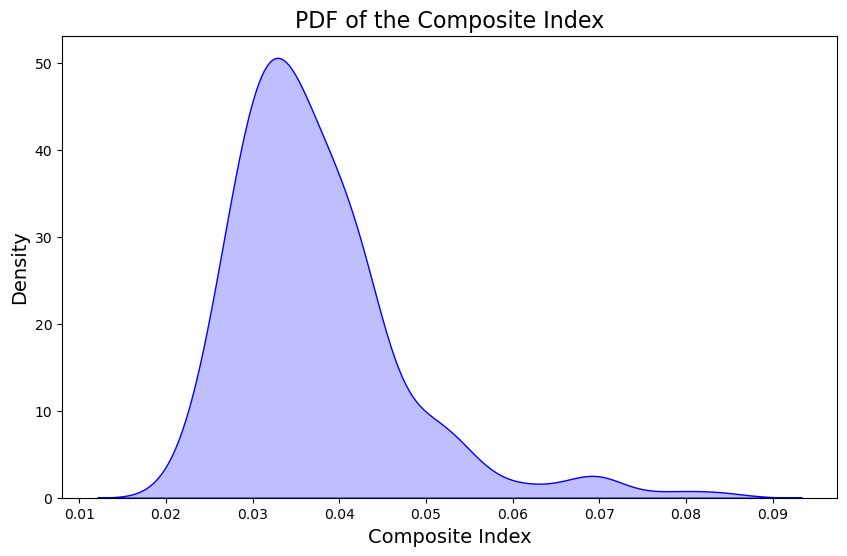

In [134]:
# Plot the PDF using seaborn's kdeplot
plt.figure(figsize=(10, 6))
sns.kdeplot(df['urban_idx'], color='blue', fill=True, bw_adjust=1)  # You can adjust bw_adjust for smoother or rougher curves

# Add title and labels
plt.title('PDF of the Composite Index', fontsize=16)
plt.xlabel('Composite Index', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Show the plot
plt.show()

In [135]:

# Save composite index to Excel file
df.to_excel('composite_index_urban_new.xlsx', index=False)


### After this step, you can use your preferred GIS software to visualize your new index.